Nesta abordagem, o treinamento ocorre da mesma forma que na forma retroalimentada, a diferença está
em como testamos o modelo. O conjunto de teste é formado através de uma janela que vai avançando a medida
que os dados são preditos.

In [1]:
# imports
%matplotlib inline
import pandas
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
import time
import datetime
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from estatisticas_time_serie import create_datasets_sliding_windows, general_forecasting
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

from sklearn.metrics import explained_variance_score, r2_score, mean_absolute_error, mean_squared_error

Using TensorFlow backend.


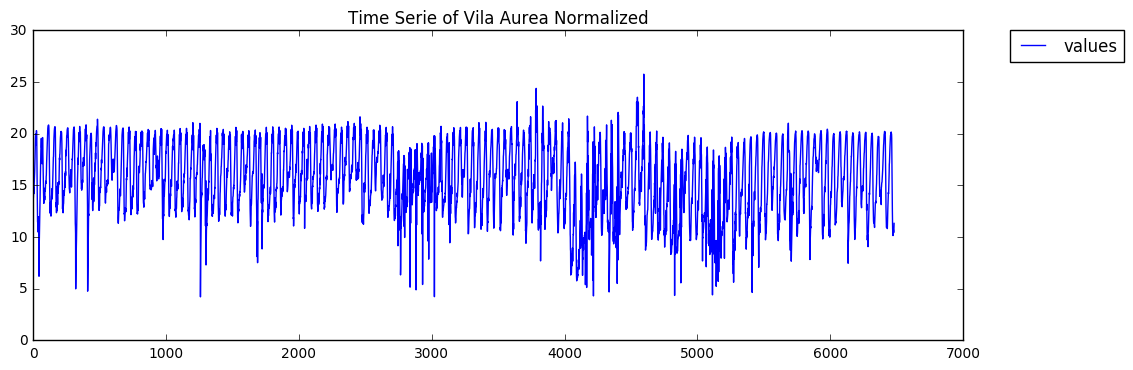

In [2]:
# load the first dataset vilacarvalho-vazao-60
dataframe = pandas.read_csv('690g-pressao-vila-aurea-4meses.csv', engine='python', skipfooter=3)
timeValues = dataframe['Time']
values     = dataframe['Value']

newV=[]
for i in values:
    if not i == 'null': 
        newV.append(float(i))

newV = np.array(newV)
def reject_outliers(data, m=3):
    return data[abs(data - np.mean(data)) < m * np.std(data)]
newV = reject_outliers(newV)

timestamps=[]
for idx,i in enumerate(timeValues):
    # skipping null values
    if not values[idx] == 'null':
        val = time.mktime(datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S").timetuple())
        timestamps.append([val])


plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(newV,label='values')
plt.title('Time Serie of Vila Aurea Normalized')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [3]:
# splitting data
train_size = int(len(newV) * 0.8)
test_size = len(newV) - train_size
train, test = newV[0:train_size], newV[train_size:train_size+test_size]
print(len(train), len(test))

(5184, 1297)


In [4]:
train_data,test_data = create_datasets_sliding_windows(newV, train_size, look_back=24)
# Using lstm
scaler = MinMaxScaler(feature_range=(0, 1))
# normalize the dataset
datasetLstm = scaler.fit_transform(newV)
train_data_lstm, test_data_lstm = create_datasets_sliding_windows(datasetLstm,train_size ,look_back = 24)
# using ARIMA
s = pd.Series(train, index=timeValues[0:train_size])

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [5]:
trainX, trainY = train_data[0],train_data[1]
testX, testY   = test_data[0], test_data[1]
trainXlstm, trainYlstm = train_data_lstm[0], train_data_lstm[1]
testXlstm, testYlstm   = test_data_lstm[0], test_data_lstm[1]
# reshape input to be [samples, time steps, features]
trainXlstm = np.reshape(trainXlstm, (trainXlstm.shape[0], 1, trainXlstm.shape[1]))
testXlstm = np.reshape(testXlstm, (testXlstm.shape[0], 1, testXlstm.shape[1]))


In [6]:
# KNN
clf_KNN = KNeighborsRegressor(n_neighbors=1)
clf_KNN.fit(trainX, trainY)

#LSTM
model = Sequential()
model.add(LSTM(10, input_dim=24))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainXlstm, trainYlstm, nb_epoch=49, batch_size=128, verbose=0)


In [8]:
#predicting
forecast_KNN = general_forecasting(testX, clf_KNN, size_forecasting=48 ,method='knn', strategy_approach='sliding_windows')
forecast_LSTM = general_forecasting(testXlstm, model, size_forecasting=48,method='lstm', strategy_approach='sliding_windows')
forecastedArima = general_forecasting(test,train=s.values,size_forecasting=48 ,classifier=None, method='arima', strategy_approach='sliding_windows')

In [9]:
# rescaling back to initial dimension
forecast_LSTM = scaler.inverse_transform(forecast_LSTM)
testYlstm = scaler.inverse_transform(testYlstm)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [10]:
print("mean_squared_error  KNN = ",mean_squared_error(testY,forecast_KNN))
print("mean_squared_error  LSTM = ",mean_squared_error(testYlstm,forecast_LSTM))
print("mean_squared_error  ARIMA = ",mean_squared_error(test,forecastedArima))

('mean_squared_error  KNN = ', 1.9966839079889538)
('mean_squared_error  LSTM = ', 0.79017084954752059)
('mean_squared_error  ARIMA = ', 0.80303116241423667)


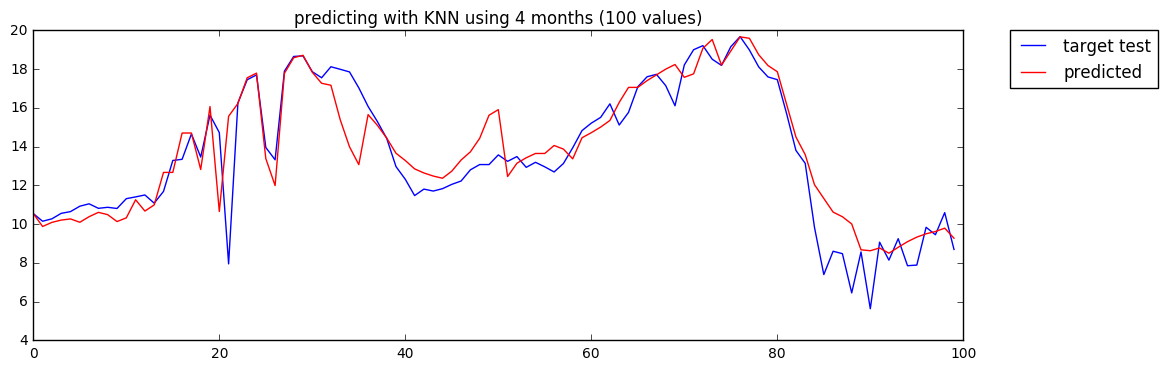

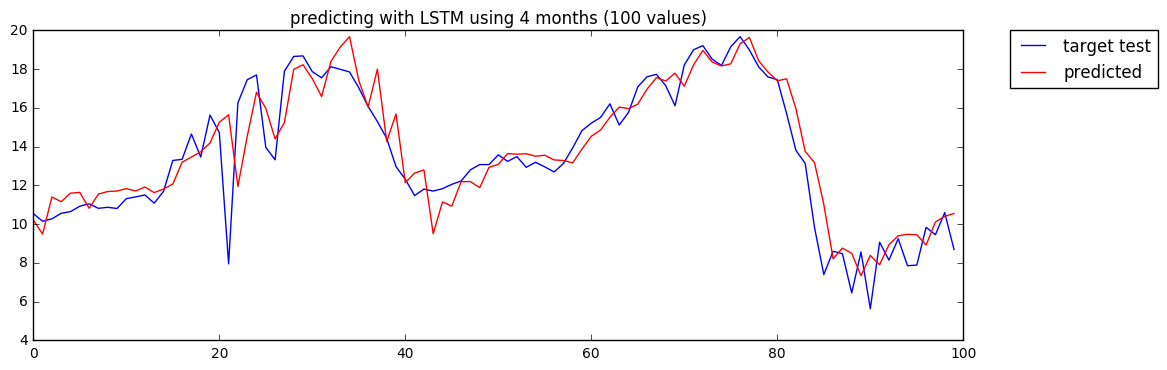

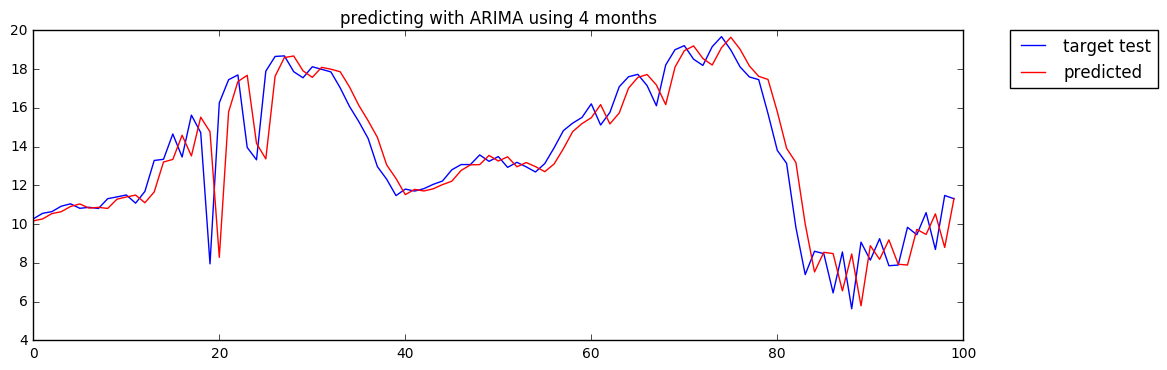

In [11]:
#plotting knn results
testPredictPlot = np.empty((len(testY)))
testPredictPlot[:] = np.nan
testPredictPlot = forecast_KNN[:100]

plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(testY[:100],color='b',label='target test')
plt.plot(testPredictPlot, color='r', label='predicted')
plt.title('predicting with KNN using 4 months (100 values)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#plotting lstm results
testPredictPlot = np.empty((int(newV.shape[0])))
testPredictPlot[:] = np.nan
testPredictPlot = forecast_LSTM[:100]

plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(testYlstm[:100],color='b',label='target test')
plt.plot(testPredictPlot, color='r', label='predicted')
plt.title('predicting with LSTM using 4 months (100 values)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#plotting arima results
testPredictPlot = np.empty((int(newV.shape[0])))
testPredictPlot[:] = np.nan
testPredictPlot = forecastedArima[:100]

plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test[:100],color='b',label='target test')
plt.plot(testPredictPlot, color='r', label='predicted')
#plt.plot(upper, color='r', label='upper interval', linestyle='--')
#plt.plot(lower[, color='r', label='lower interval', linestyle='--')
plt.title('predicting with ARIMA using 4 months')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()